### Unsloth based multimodal finetuning
Used Qwen2-VL-2B-Instruct for its size, performance and ability to read Chinese. 

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'
# os.environ["WORLD_SIZE"] = "1"

In [3]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm
from PIL import Image
import imagesize
from qwen_vl_utils import process_vision_info
from transformers import TextStreamer
from transformers import AutoModelForVision2Seq, AutoProcessor, LlavaForConditionalGeneration
from peft import get_peft_model, LoraConfig, AutoPeftModelForCausalLM, PeftModel, PeftConfig, prepare_model_for_kbit_training
from transformers import TrainingArguments
from unsloth import FastVisionModel # FastLanguageModel for LLMs
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
from datasets import Dataset, load_dataset
import requests

/workspace/jupyter_notebooks/abhinav/llama32_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


### Create data loaders
1. 50_000 train
2. 5_k validate

In [5]:
instruction = """
Analyse the image carfully and return the text in English, Chinese and the description of any pattern if present. Return the answer as json string.
"""

def transforms(examples):
    examples["image"] = [Image.open(image) for image in examples["image_path"]]
    return examples

def format_data(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["answer"]} ]
        },
    ]
    return { "messages" : conversation }
pass



In [6]:
train = pd.read_csv("./trademark_train.csv")
valid = pd.read_csv("trademark_test.csv")
train = train.loc[~train.image_path.str.contains('.bmp')]
valid = valid.loc[~valid.image_path.str.contains('.bmp')]
# train["image_path"] = train.url.apply(lambda x: f"./images/{x.split('/')[-1]}")
# valid["image_path"] = valid.url.apply(lambda x: f"./images/{x.split('/')[-1]}")
train = train.loc[train["img_width"] < 1000].sample(50_000, random_state=42)
valid = valid.loc[valid["img_width"] < 1000].sample(5_000, random_state=42)
train.reset_index(inplace=True, drop=True)
valid.reset_index(inplace=True, drop=True)
valid.columns

/tmp/ipykernel_1263412/3352756257.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("./trademark_train.csv")


Index(['date_str', 'wordsInMark', 'chineseCharacter', 'url', 'descrOfDevice',
       'downloaded', 'answer', 'image_path', 'img_width'],
      dtype='object')

https://ipos-storage.data.gov.sg/trademarks/T1005701H/f34109c0-cc88-43a6-afd4-9a085749fc02/T1005701H.jpg


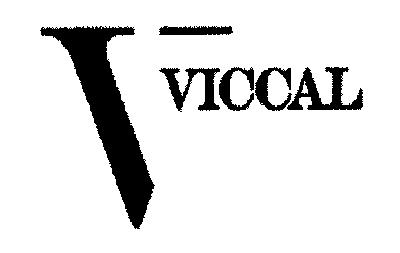

In [7]:
sample = valid.sample(1)
print(sample.url.values[0])
Image.open(sample.image_path.values[0])

In [8]:
train_dataset = Dataset.from_pandas(train)
valid_dataset = Dataset.from_pandas(valid)

train_dataset.set_transform(transforms)
valid_dataset.set_transform(transforms)

In [9]:
# train_dataset = [format_data(sample) for sample in train_dataset]
valid_dataset = [format_data(sample) for sample in valid_dataset]

In [ ]:
# FastVisionModel.for_inference(model) # Enable for inference!

# image = valid_dataset[2]["image"]

# messages = [
#     {"role": "user", "content": [
#         {"type": "image"},
#         {"type": "text", "text": instruction}
#     ]}
# ]
# input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
# inputs = tokenizer(
#     image,
#     input_text,
#     add_special_tokens = False,
#     return_tensors = "pt",
# ).to("cuda")

# from transformers import TextStreamer
# text_streamer = TextStreamer(tokenizer, skip_prompt = True)
# _ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
#                    use_cache = True, temperature = 1.5, min_p = 0.1)

### Train the model
training the model for 1 epoch

In [ ]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-2B-Instruct",
    load_in_4bit = False, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers
    target_modules = ["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = train_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # max_steps = 30,
        num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 100,
        save_strategy='steps',
        save_steps=500,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [ ]:
trainer_stats = trainer.train(resume_from_checkpoint=True)

In [ ]:
model.save_pretrained(f"final_chkpt") # Local saving
tokenizer.save_pretrained(f"final_chkpt")
model.save_pretrained_merged(f"model_v1_4bit", 
                             tokenizer, save_method = "merged_16bit",)

### Inference
In production I would use VLLM since this is a takehome I am not using it for simplicity

In [104]:
import pandas as pd
import ast 
import json
from fuzzywuzzy import fuzz
from glob import glob
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from transformers import TextStreamer

In [13]:
save_folder = "model_v1_16bit"

In [14]:

model, tokenizer = FastVisionModel.from_pretrained(
    model_name = save_folder, # YOUR MODEL YOU USED FOR TRAINING
    load_in_4bit = False, # Set to False for 16bit LoRA
)
FastVisionModel.for_inference(model); # Enable for inference!

==((====))==  Unsloth 2025.2.4: Fast Qwen2_Vl vision patching. Transformers: 4.51.3.
   \\   /|    GPU: NVIDIA A100-SXM4-80GB. Max memory: 79.138 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


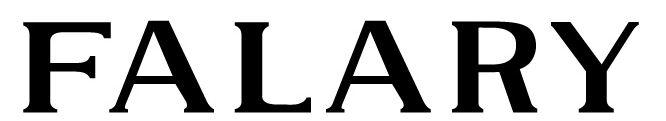

In [91]:
index = 99
image = valid_dataset[index]['messages'][0]['content'][1]['image']
instruction = valid_dataset[index]['messages'][0]['content'][0]['text']
image

In [92]:
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")


text_streamer = TextStreamer(tokenizer, skip_prompt = True)
op = model.generate(**inputs, 
                    # streamer = text_streamer,
                    max_new_tokens = 1000,
                   use_cache = True, temperature = 0.1)
op = tokenizer.decode(op[0])
op.split("<|im_start|>assistant")[-1].strip("\n").replace("<|im_end|>", "")

'{"wordsInMark": "falary", "chineseCharacter": "", "descrOfDevice": ""}'

### For validation data, bonus evaluation

In [60]:
def infervalid(index):
    image = valid_dataset[index]['messages'][0]['content'][1]['image']
    if image.width > 512 or image.height > 512:
            image = image.resize((512, 512), Image.Resampling.LANCZOS)
        
    if image.width<30 or image.height<30:
        image = image.resize((max(image.width, 30), max(image.height, 30)), Image.Resampling.LANCZOS)
    instruction = valid_dataset[index]['messages'][0]['content'][0]['text']
    messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens = False,
        return_tensors = "pt",
    ).to("cuda")


    text_streamer = TextStreamer(tokenizer, skip_prompt = True)
    op = model.generate(**inputs, 
                        # streamer = text_streamer,
                        max_new_tokens = 1000,
                       use_cache = True, temperature = 0.1)
    op = tokenizer.decode(op[0])
    return op.split("<|im_start|>assistant")[-1].strip("\n").replace("<|im_end|>", "")
    

# compare groundtruth and predicted for the 1st 100 samples
valid_ops = [infervalid(index_) for index_ in tqdm(range(100))]
    

100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


In [76]:
valid_ops[44]

'{"wordsInMark": "asahi breweries limited super dry asahi dry black", "chineseCharacter": "\\u751f", "descrOfDevice": "sheaf sheaves japanese"}'

In [112]:
def get_compenents(row):
    try:
        x = ast.literal_eval(row["predicted_op"])
        return x['wordsInMark'], x['chineseCharacter'], x['descrOfDevice']
    except:
        return None, None, None
    
def is_bad(value):
    if (value != value) | (value is None):
        return True
    else:
        return False

def fuzzy_sim_token_sort(s1, s2):
    if s1 == "" or s2 == "" or is_bad(s1) or is_bad(s1):
        return 0
    else:
        return fuzz.token_sort_ratio(s1, s2)
    
def fuzzy_sim_token_set(s1, s2):
    if s1 == "" or s2 == "" or is_bad(s1) or is_bad(s1):
        return 0
    else:
        return fuzz.token_set_ratio(s1, s2)
    
    
predicted_op = pd.DataFrame({"predicted_op":valid_ops})
predicted_op[["wordsInMark_pred", "chineseCharacter_pred", "descrOfDevice_pred"]] = predicted_op.apply(
    get_compenents, axis=1, result_type="expand")

In [97]:
# 1 prediction in 100 fails
predicted_op.loc[predicted_op.wordsInMark_pred.isna()]

,predicted_op,wordsInMark_pred,chineseCharacter_pred,descrOfDevice_pred
42,"{""wordsInMark"": ""ok everyday low price"", ""chin...",None,None,None


In [103]:
results = pd.concat([valid[["wordsInMark", "chineseCharacter", "descrOfDevice"]].head(100), predicted_op], axis=1).drop(columns=["predicted_op"])
results.fillna("", inplace=True)

In [109]:
results

,wordsInMark,chineseCharacter,descrOfDevice,wordsInMark_pred,chineseCharacter_pred,descrOfDevice_pred
0,techforgood tech good,,heart,tech for good,,heart
1,fg foodgears food gears,,,fg food gears,,angled stripe
2,bodi,,,bodi,,
3,neuromethod,,,neuromethod,,
4,biznet global,,globe,biznet global,,globe
...,...,...,...,...,...,...
95,ecomax,,,ecomax,,lightning
96,mhg,,,mhg,,
97,KOOL,,interlocking rings diverging rays,kool,,curls flame
98,n gold,純硬金,overlapping ovals,n gold,尚爾金,pebbles


In [116]:
# the english text is extracted well, some nuances are yet to be captured. This can be fixed by training longer with all the data.
results.apply(lambda row: fuzzy_sim_token_sort(row["wordsInMark"], 
row["wordsInMark_pred"]), axis=1).quantile([0.25, 0.5, 0.75, 0.95])

0.25     98.0
0.50    100.0
0.75    100.0
0.95    100.0
dtype: float64

In [120]:
# the Chinese charachter extraction can definitely be improved but the sample size is a bit small
results.loc[results.chineseCharacter.str.len() > 0].apply(lambda row: fuzzy_sim_token_sort(row["chineseCharacter"], 
row["chineseCharacter_pred"]), axis=1)


32      0
41    100
42      0
44    100
47    100
56     83
98     33
dtype: int64

In [122]:
# there is room for improvement here. I suggest training for longer with more data. In many cases the description groundth truth is quite subjective
results.loc[results.descrOfDevice.str.len() > 0].apply(lambda row: fuzzy_sim_token_sort(row["descrOfDevice"], 
row["descrOfDevice_pred"]), axis=1).quantile([0.25, 0.5, 0.75, 0.95])

0.25     21.0
0.50     39.0
0.75    100.0
0.95    100.0
dtype: float64

### Huggingface inference

In [ ]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor

from qwen_vl_utils import process_vision_info

# default: Load the model on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "final_chkpt/", torch_dtype="auto", device_map="auto"
)

In [ ]:
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")


In [ ]:
index = 467
image = valid_dataset[index]['messages'][0]['content'][1]['image']
instruction = valid_dataset[index]['messages'][0]['content'][0]['text']
image

In [ ]:
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = processor.apply_chat_template(messages, add_generation_prompt = True)

inputs = processor(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")


op = model.generate(**inputs, 
                    # streamer = text_streamer,
                    max_new_tokens = 1000,
                   use_cache = True, temperature = 0.1)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, op)
]

In [ ]:
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)